In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import xml.etree.ElementTree as ET
import os

import torch.nn as nn

class bones_dataset(Dataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['fracture', 'background']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.images_fps = images_dir
        self.masks_fps = masks_dir
        
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __getitem__(self, i):

        image = cv2.imread(self.images_fps[i])
        
        tree = ET.parse(self.masks_fps[i])
        root = tree.getroot()
        width, height, _ = image.shape
        
        mask = np.zeros(image.shape[:2])  # mask should be one-dimensional
        
        for objects in root.iter('bndbox'):
            x_min, y_min = (int(float(objects.find('xmin').text)), int(float(objects.find('ymin').text)))
            x_max, y_max = (int(float(objects.find('xmax').text)), int(float(objects.find('ymax').text)))

            mask = cv2.rectangle(mask, (x_min, y_max), (x_max, y_min), 1, -1)

        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask
        
    def __len__(self):
        return len(self.images_fps)

In [2]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [3]:
path_to_train_imgs = "xray/arm fracture/training/"
path_to_train_masks =  "xray/arm fracture/training annotations/"

images_train = sorted([path_to_train_imgs + filename for filename in os.listdir(path_to_train_imgs)])
masks_train = sorted([path_to_train_masks + filename for filename in os.listdir(path_to_train_masks)])

path_to_valid_imgs = "xray/arm fracture/validation/"
path_to_valid_masks =  "xray/arm fracture/validation annotations/"

images_valid = sorted([path_to_valid_imgs + filename for filename in os.listdir(path_to_valid_imgs)])
masks_valid = sorted([path_to_valid_masks + filename for filename in os.listdir(path_to_valid_masks)])

In [4]:
dataset = bones_dataset(images_train, masks_train, classes=['fracture'])
print(len(dataset))

37


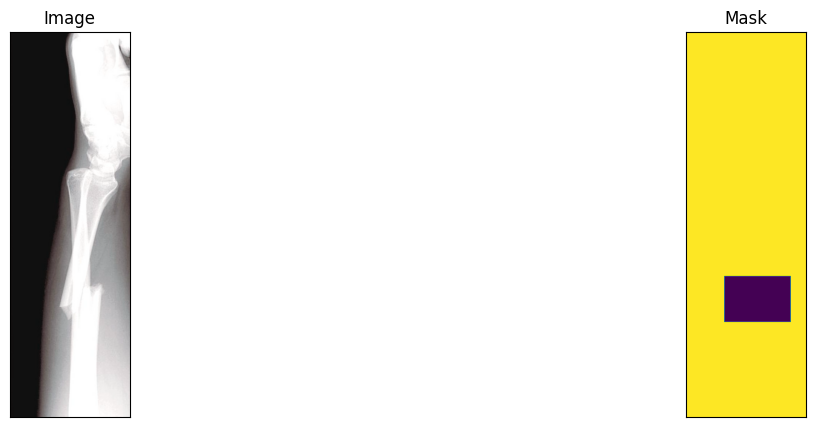

(1008, 313, 3)

In [5]:
image, mask = dataset[36] # get some sample
visualize(
    image=image, 
    mask=mask.squeeze(),
)
image.shape

In [6]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [
        albu.Resize(224,224),
        albu.Flip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    test_transform = [
        albu.Resize(224,224),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

(224, 224, 3)


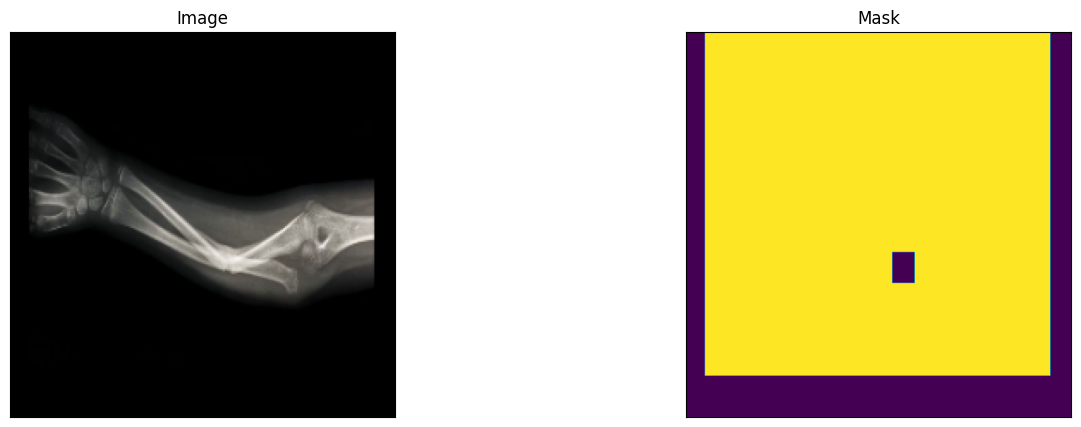

(224, 224, 3)


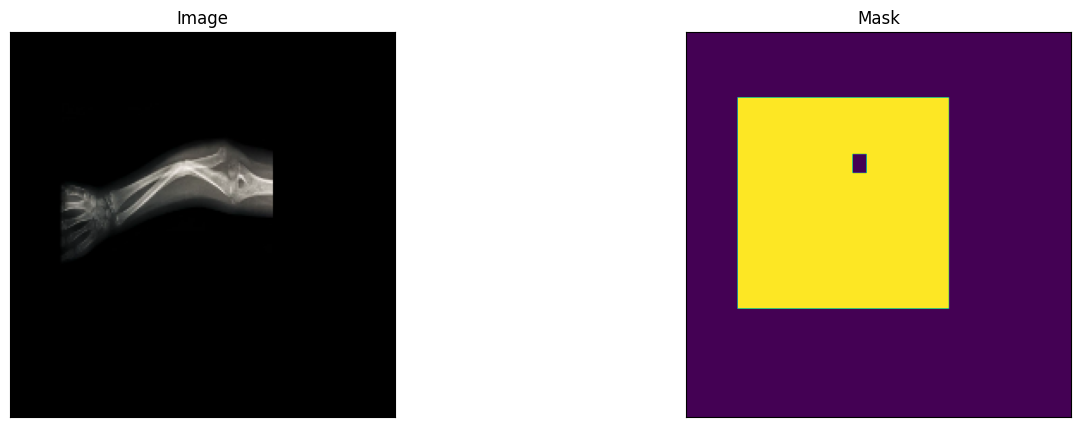

(224, 224, 3)


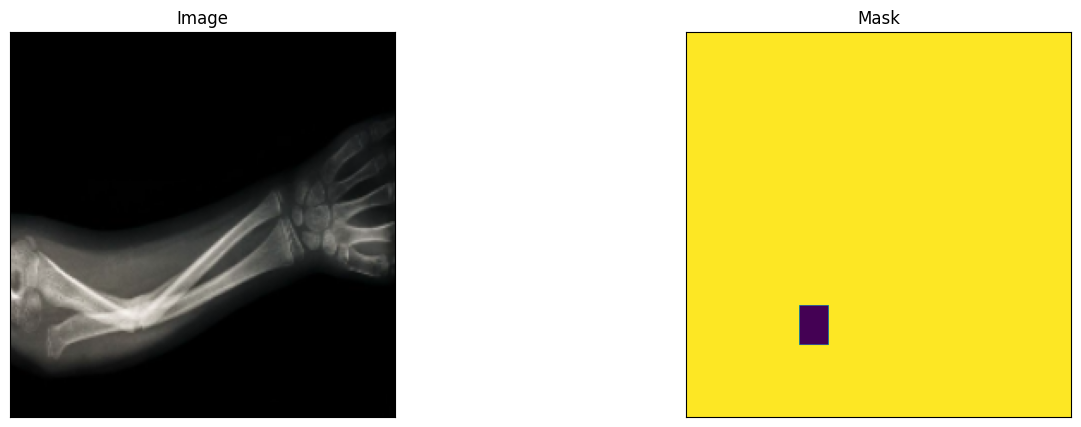

In [7]:
augmented_dataset = bones_dataset(
    images_train, 
    masks_train, 
    augmentation=get_training_augmentation(), 
    classes=['fracture'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    print(image.shape)
    visualize(image=image, mask=mask.squeeze(-1))

In [8]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

import torch
import numpy as np

import segmentation_models_pytorch as smp

ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['fracture']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cpu'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


train_dataset = bones_dataset(
    images_train, 
    masks_train, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = bones_dataset(
    images_valid, 
    masks_valid, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

In [9]:
im = train_dataset[0]

In [10]:
import segmentation_models_pytorch.utils

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.AdamW([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [11]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [13]:
max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './work_model.pth')
        print('Model saved! Score: ', max_score)
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train: 100%|█| 10/10 [00:00<00:00, 11.53it/s, dice_loss - 0.07057, iou_score - 0
valid: 100%|█| 5/5 [00:00<00:00, 34.00it/s, dice_loss - 0.06061, iou_score - 0.9
Model saved! Score:  0.9725231409072876

Epoch: 1
train: 100%|█| 10/10 [00:00<00:00, 11.57it/s, dice_loss - 0.0816, iou_score - 0.
valid: 100%|█| 5/5 [00:00<00:00, 38.32it/s, dice_loss - 0.05143, iou_score - 0.9
Model saved! Score:  0.9777735829353332

Epoch: 2
train: 100%|█| 10/10 [00:00<00:00, 12.33it/s, dice_loss - 0.06948, iou_score - 0
valid: 100%|█| 5/5 [00:00<00:00, 36.46it/s, dice_loss - 0.05766, iou_score - 0.9

Epoch: 3
train: 100%|█| 10/10 [00:00<00:00, 12.52it/s, dice_loss - 0.07055, iou_score - 0
valid: 100%|█| 5/5 [00:00<00:00, 38.62it/s, dice_loss - 0.05023, iou_score - 0.9
Model saved! Score:  0.9779404878616333

Epoch: 4
train: 100%|█| 10/10 [00:00<00:00, 11.84it/s, dice_loss - 0.08109, iou_score - 0
valid: 100%|█| 5/5 [00:00<00:00, 37.96it/s, dice_loss - 0.05882, iou_score - 0.9

Epoch: 5
train: 100

In [12]:
best_model = torch.load('./work_model.pth', map_location=torch.device('cpu'))

In [13]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(valid_loader)

valid: 100%|█| 5/5 [00:00<00:00,  9.52it/s, dice_loss - 0.0478, iou_score - 0.97


In [14]:
class test_bones_dataset(Dataset):
    
    CLASSES = ['fracture', 'background']
    
    def __init__(
            self, 
            images_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.images_fps = images_dir
        
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __getitem__(self, i):

        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']

        return image
        
    def __len__(self):
        return len(self.images_fps)

In [15]:
test_dataset = test_bones_dataset(
    images_valid, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)
showset = test_bones_dataset(images_valid, classes=CLASSES)

(1024, 344, 3)
(1024, 344)


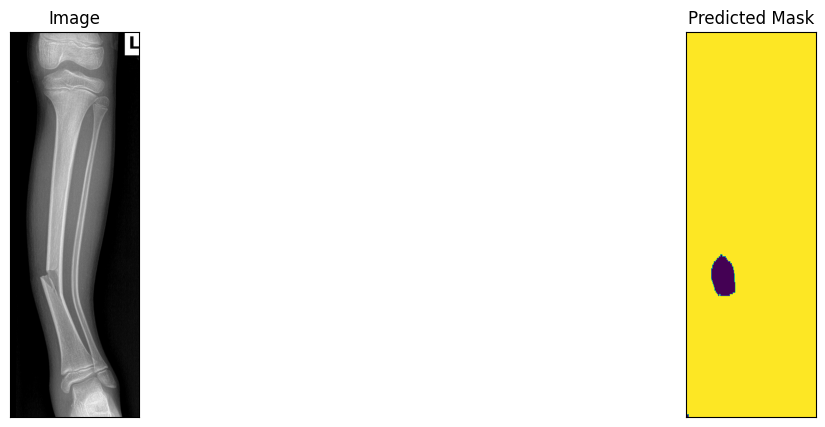

(1024, 344)
(1024, 344)


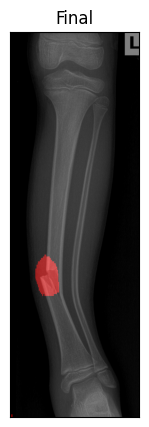

(1024, 344)


In [39]:
image_vis = showset[1]
image = test_dataset[1]
print(image_vis.shape)
h, w = image_vis.shape[:2]

best_model.eval()
with torch.no_grad():
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    out = best_model(x_tensor).squeeze().cpu().numpy().round()
    out = cv2.resize(out, (w, h)).astype('uint8')
    print(out.shape)

visualize(
        image=image_vis, 
        predicted_mask=out
    )

ret,thresh = cv2.threshold(out, 0.5, 255, cv2.THRESH_BINARY_INV)
print(thresh.shape)
pure = np.zeros(thresh.shape).astype('uint8')
print(pure.shape)
out3 = cv2.merge((thresh, pure, pure))
res = cv2.addWeighted(image_vis,0.5,out3,0.5,0)
visualize(final=res)
print(out.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1974, 616, 3)
(224, 224, 3)


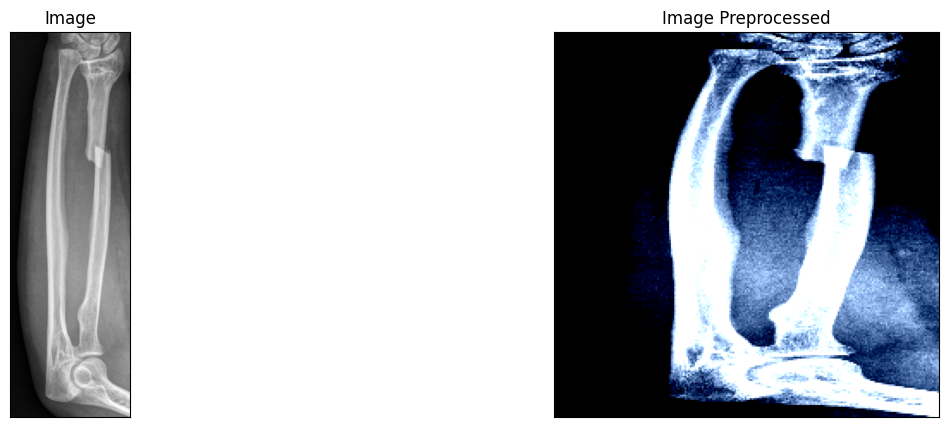

torch.Size([1, 3, 224, 224])


In [38]:
img_ = cv2.imread('xray/arm fracture/training/1.jpg')

img_preprocessed = preprocessing_fn(img_)
print(img_preprocessed.shape)

img_preprocessed = cv2.resize(img_preprocessed, (224,224))
print(img_preprocessed.shape)

visualize(image=img_, image_preprocessed=img_preprocessed)

img_tensor = torch.from_numpy(img_preprocessed).permute(2, 0, 1)
print(img_tensor.unsqueeze(0).size())

In [24]:
best_model.eval() 
torch.onnx.export(best_model.float(),
                 img_tensor.float().unsqueeze(0),
                 "arm_fractures_unet_resnext50.onnx",
                 export_params=True,
                 opset_version=12,
#                  opset_version=10,
#                  do_constant_folding=True
                 )

/home/wladimir/jupiterspace/jupiterspace/lib/python3.8/site-packages/segmentation_models_pytorch/base/model.py:16: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:


============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

